In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')

import torch
import math
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datetime import datetime
from models import PreResNet
from models import AlexNet
# from models import AlexNetesN
import os

Mounted at /content/drive


In [ ]:

def load_data_cifar10():
    transform_train = transforms.Compose(
     [transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

    transform_test = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

    train_set = torchvision.datasets.CIFAR10(
        root='.data', train=True, download=True, transform=transform_train)

    test_set = torchvision.datasets.CIFAR10(
        root='.data', train=False, download=True, transform=transform_test)
    return train_set, test_set


def load_data_mnist():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_set = torchvision.datasets.MNIST(
        root='.data', train=True, download=True, transform=transform)

    test_set = torchvision.datasets.MNIST(
        root='.data', train=False, download=True, transform=transform)
    return train_set, test_set


train_set, test_set = load_data_cifar10()
n_data = train_set.data.shape[0]

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting .data/cifar-10-python.tar.gz to .data
Files already downloaded and verified


In [ ]:
def forward(batch, model):
    images, labels = batch
    logits = model(images)
    _, predictions = logits.max(1)
    correct = (predictions == labels).sum()
    loss = F.cross_entropy(logits, labels, reduction='mean')
    return loss, correct


def validation(test_loader, model):
    n = 0
    correct_count = 0.0
    total_loss = 0.0
    test_iter = iter(test_loader)
    with torch.no_grad():
        for images, labels in test_iter:
            batch = (images.to(device), labels.to(device))
            batch_size = batch[0].shape[0]
            n += batch_size
            average_loss, correct = forward(batch, model)
            total_loss += average_loss * batch_size
            correct_count += correct
    return total_loss.item() / n, correct_count.item() / n


def train_one_epoch(epoch_index, train_loss, train_accuracy, train_index):
    correct = 0
    n_total = 0
    running_loss = 0
    for i, (images, labels) in enumerate(train_iter):
        n = images.shape[0] // 2
        optimizer.zero_grad()
        batch1 = (images[:n].to(device), labels[:n].to(device))
        batch2 = (images[n:].to(device), labels[n:].to(device))

        loss1, correct1 = forward(
            batch1, model)
        loss2, correct2 = forward(batch2, model)
        loss = c1 * loss1 + c2 * loss2

        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        train_accuracy.append((correct1 + correct2).item() / (2 * n))

torch.manual_seed(5)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
timestamp_experiment = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_type = 'resnet'
linear_scaling = 8
batch_size = 128 * linear_scaling
if model_type == 'resnet':
  learning_rate = 0.8 * linear_scaling
else:
  learning_rate = 0.4 * linear_scaling
run_directory = f'/content/drive/My Drive/Colab Notebooks/runs/{model_type}_{timestamp_experiment}_{batch_size}'
os.makedirs(run_directory)
os.makedirs(run_directory +'/final')
model_path = f'/content/drive/My Drive/Colab Notebooks/checkpoints/{model_type}_{timestamp_experiment}.pt'

for noise_scaling in [16]:
  train_loss = []
  test_loss = []
  train_accuracy = []
  test_accuracy = []
  test_index = []
  train_index = []
  if model_type == 'resnet':
    model = PreResNet(32)
  else:
    model = AlexNet(num_classes=10)
  checkpoint = torch.load('/content/drive/My Drive/Colab Notebooks/checkpoints/resnet_2022-12-25_19-55-16.pt')
  model.load_state_dict(checkpoint['model_state_dict'])
  model.to(device)

  timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

  effective_learning_rate = learning_rate / noise_scaling
  weight_decay = 0.0005
  n_epochs = 80
  n_effective_epochs = n_epochs * noise_scaling
  # hyperparameters = {'batch size': batch_size, 'noise scaling': noise_scaling,
  #                   'learning rate': learning_rate, 'weight decay': weight_decay, 'number of epochs': n_epochs, 'number of effective epochs': n_effective_epochs, 'effective learning rate': effective_learning_rate}

  trainloader = torch.utils.data.DataLoader(
      train_set, batch_size=2 * batch_size, shuffle=True, num_workers=2)
  testloader = torch.utils.data.DataLoader(
      test_set, batch_size=2 * batch_size, shuffle=True, num_workers=2)
  optimizer = torch.optim.SGD(
      model.parameters(), lr=learning_rate/noise_scaling, weight_decay=weight_decay)
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=int(n_effective_epochs * 0.8), gamma=0.1)
  scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
  c1 = (1 + math.sqrt(2 * noise_scaling - 1)) / 2
  c2 = (1 - math.sqrt(2 * noise_scaling - 1)) / 2
  # for epoch in tqdm(range(n_effective_epochs)):
  for epoch in tqdm(range(checkpoint['epoch']+1, n_effective_epochs)):
      validation_loss, validation_accuracy = validation(testloader, model)
      print(
          f'Epoch: {epoch}/{n_effective_epochs}, loss: {validation_loss:.4f}, validation accuracy: {validation_accuracy:.4f}')
      test_index.append(epoch * len(trainloader))
      test_loss.append(validation_loss)
      test_accuracy.append(validation_accuracy)
      train_iter = iter(trainloader)
      train_one_epoch(epoch, train_loss, train_accuracy, train_index)
      scheduler.step()
      if epoch % 40 == 39 or epoch == n_effective_epochs-1:
        torch.save({'epoch':epoch, 'model_state_dict':model.state_dict(), 'optimizer_state_dict':optimizer.state_dict(), 'scheduler_state_dict': scheduler.state_dict()}, model_path)
        torch.save(train_loss,run_directory+f'/train_loss_{noise_scaling}.pt')
        torch.save(train_accuracy, run_directory+f'/train_accuracy_{noise_scaling}.pt')
        torch.save(test_loss, run_directory+f'/test_loss_{noise_scaling}.pt')
        torch.save(test_accuracy, run_directory+f'/test_accuracy_{noise_scaling}.pt')
      if epoch == n_effective_epochs-1:
        torch.save(train_loss,run_directory+f'/final/train_loss_{noise_scaling}.pt')
        torch.save(train_accuracy, run_directory+f'/final/train_accuracy_{noise_scaling}.pt')
        torch.save(test_loss, run_directory+f'/final/test_loss_{noise_scaling}.pt')
        torch.save(test_accuracy, run_directory+f'/final/test_accuracy_{noise_scaling}.pt')


  0%|          | 0/960 [00:00<?, ?it/s]

Epoch: 320/1280, loss: 0.7107, validation accuracy: 0.7743
Epoch: 321/1280, loss: 0.6203, validation accuracy: 0.7940
Epoch: 322/1280, loss: 0.6471, validation accuracy: 0.7857
Epoch: 323/1280, loss: 0.7570, validation accuracy: 0.7547
Epoch: 324/1280, loss: 0.7554, validation accuracy: 0.7517
Epoch: 325/1280, loss: 0.6552, validation accuracy: 0.7840
Epoch: 326/1280, loss: 0.6210, validation accuracy: 0.8005
Epoch: 327/1280, loss: 0.8351, validation accuracy: 0.7491
Epoch: 328/1280, loss: 0.5987, validation accuracy: 0.8002
Epoch: 329/1280, loss: 0.7088, validation accuracy: 0.7696
Epoch: 330/1280, loss: 0.6017, validation accuracy: 0.7993
Epoch: 331/1280, loss: 0.5795, validation accuracy: 0.8066
Epoch: 332/1280, loss: 0.6371, validation accuracy: 0.7852
Epoch: 333/1280, loss: 0.7237, validation accuracy: 0.7686
Epoch: 334/1280, loss: 0.7218, validation accuracy: 0.7686
Epoch: 335/1280, loss: 0.7142, validation accuracy: 0.7689
Epoch: 336/1280, loss: 0.6709, validation accuracy: 0.78

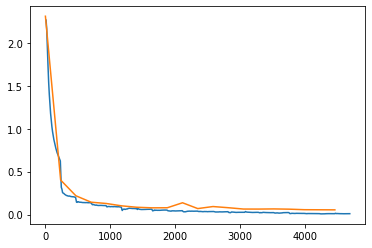

In [ ]:
plt.plot(train_index, train_loss)
plt.plot(test_index, test_loss)

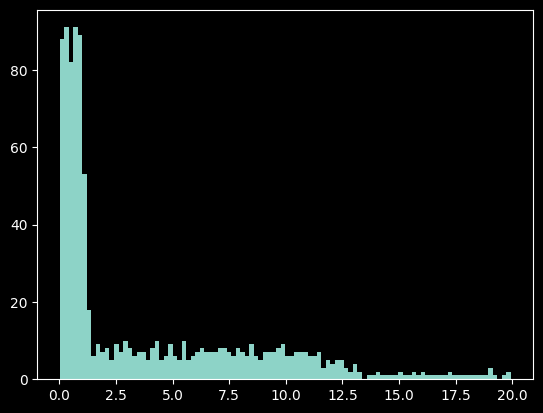

In [ ]:
# history = calculate_norms(model, trainloader)

gradient_norms = [gradient for iterate in history for gradient in iterate['gradient']]
plt.hist(gradient_norms, bins=100);
# gradient_norms

In [ ]:
# model = torch.nn.Sequential(torch.nn.Flatten(), torch.nn.Linear(
#     28 * 28, 512), torch.nn.Linear(512, 512), torch.nn.ReLU(), torch.nn.Linear(512, 512), torch.nn.ReLU(), torch.nn.Linear(512, 10))
model = AlexNet(num_classes=10)
model.to(device)

def forward(batch, model):
    images, labels = batch
    logits = model(images)
    _, predictions = logits.max(1)
    correct = (predictions == labels).sum()
    loss = F.cross_entropy(logits, labels, reduction='mean')
    return loss, correct


def validation(test_loader, model):
    n = 0
    correct_count = 0.0
    total_loss = 0.0
    test_iter = iter(test_loader)
    with torch.no_grad():
        for images, labels in test_iter:
            batch = (images, labels)
            batch_size = batch[0].shape[0]
            n += batch_size
            average_loss, correct = forward(batch, model)
            total_loss += average_loss * batch_size
            correct_count += correct
    return total_loss.item() / n, correct_count.item() / n


batch_size = 128
noise_scaling = 1
trainloader = torch.utils.data.DataLoader(
    train_set, batch_size=60000, shuffle=True, num_workers=0)
losses = []
accuracies = []
validation_losses = []
validation_accuracies = []
learning_rate = 0.12
weight_decay = 0.0005
epochs = 10
learning_rates = 10 ** torch.linspace(-6, 0, 5000)
c1 = (1 + math.sqrt(2 * noise_scaling - 1)) / 2
c2 = (1 - math.sqrt(2 * noise_scaling - 1)) / 2
optimizer = torch.optim.SGD(
    model.parameters(), lr=learning_rate/noise_scaling, weight_decay=weight_decay)
images, labels = next(iter(trainloader))
for i in range(5000):
    for g in optimizer.param_groups:
        g['lr'] = learning_rates[i] / noise_scaling
    ix = torch.randint(0, images.shape[0], (2 * batch_size,))
    batch1 = (images[ix[:batch_size]].to(device), labels[ix[:batch_size]].to(device))
    batch2 = (images[ix[batch_size:]].to(device), labels[ix[batch_size:]].to(device))
    optimizer.zero_grad()

    loss1, correct1 = forward(
        batch1, model)
    loss2, correct2 = forward(batch2, model)
    loss = c1 * loss1 + c2 * loss2

    losses.append(loss.item())
    for p in model.parameters():
        p.grad = None
    loss.backward()
    optimizer.step()
    print(f'{i} / {len(train_iter)-1}, loss: {losses[-1]:.3f}')


Streaming output truncated to the last 5000 lines.
0 / 24, loss: 2.302
1 / 24, loss: 2.306
2 / 24, loss: 2.302
3 / 24, loss: 2.304
4 / 24, loss: 2.303
5 / 24, loss: 2.300
6 / 24, loss: 2.302
7 / 24, loss: 2.304
8 / 24, loss: 2.307
9 / 24, loss: 2.303
10 / 24, loss: 2.301
11 / 24, loss: 2.306
12 / 24, loss: 2.304
13 / 24, loss: 2.305
14 / 24, loss: 2.300
15 / 24, loss: 2.300
16 / 24, loss: 2.303
17 / 24, loss: 2.303
18 / 24, loss: 2.303
19 / 24, loss: 2.304
20 / 24, loss: 2.301
21 / 24, loss: 2.306
22 / 24, loss: 2.306
23 / 24, loss: 2.307
24 / 24, loss: 2.302
25 / 24, loss: 2.303
26 / 24, loss: 2.298
27 / 24, loss: 2.300
28 / 24, loss: 2.308
29 / 24, loss: 2.304
30 / 24, loss: 2.300
31 / 24, loss: 2.303
32 / 24, loss: 2.304
33 / 24, loss: 2.306
34 / 24, loss: 2.302
35 / 24, loss: 2.300
36 / 24, loss: 2.304
37 / 24, loss: 2.305
38 / 24, loss: 2.300
39 / 24, loss: 2.301
40 / 24, loss: 2.302
41 / 24, loss: 2.301
42 / 24, loss: 2.305
43 / 24, loss: 2.306
44 / 24, loss: 2.300
45 / 24, loss:

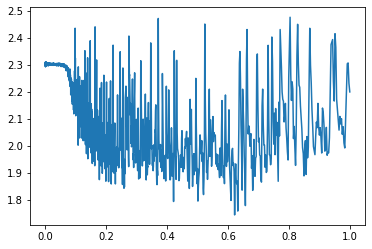

In [ ]:

filtered_losses = [(learning_rate, value) for learning_rate, value in zip(
    learning_rates.tolist(), losses) if not math.isnan(value) and value < 2.5]
lr = [learning_rate for learning_rate, _ in filtered_losses]
l = [loss for _, loss in filtered_losses]
plt.plot(lr, l)


In [ ]:
dataiter = iter(trainloader)
next(dataiter)

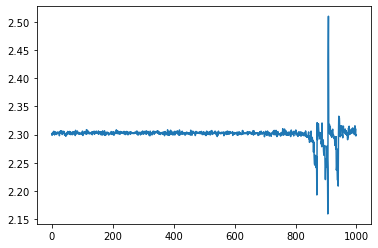

In [ ]:
plt.plot(losses)

In [ ]:
dataiter = iter(testloader)

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (labels == predicted).sum().item()
correct / total

0.5078